# **CSCI 566 - Spring 2025 - Homework 1**
# **Problem 2: Basics of Neural Networks**

## **Learning Objective**
In this problem, you will implement a **multi-layer fully connected neural network** from scratch. The goal is to:
- Understand and implement **forward and backward passes** of neural network layers.
- Develop **different optimization techniques** to train the network.
- Train and evaluate a model from scratch.

---

## **Provided Code**
We have provided the skeleton of classes that you need to complete:
- **Forward checking** and **gradient checking** functions are included to verify your implementations.
- Helper functions for dataset loading and visualization.

---

## **TODOs**
You need to implement the following:

1. **Forward and backward passes** for standard neural network layers.
2. Implement the following **loss functions**:
   - Mean Squared Error (MSE)
   - Softmax with Cross-Entropy
3. Implement **common optimization algorithms**:
   - Stochastic Gradient Descent (SGD)
   - Adam
   - RMSprop
4. **Training a neural network** from scratch and tuning hyperparameters.
5. **Inline questions**: You are required to answer conceptual questions within the notebook.

---

## **Dataset: Fashion MNIST**
Fashion MNIST consists of **70,000 grayscale images** of size **28×28** in **10 classes**, including:
- T-shirts
- Sneakers
- Bags
- Dresses, etc.

---

In [25]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [27]:
import os
from torchvision.datasets import FashionMNIST
from sklearn.model_selection import train_test_split

def _extract_arrays(dset):
    x = dset.data.numpy().astype(np.float32) / 255.0
    y = np.array(dset.targets, dtype=np.int64)
    return x, y

def fashionMnist():
    download = not os.path.isdir("fashionMnist-batches-py")
    dset_train = FashionMNIST(root=".", download=download, train=True)
    dset_test = FashionMNIST(root=".", train=False)
    x_train, y_train = _extract_arrays(dset_train)
    x_test_val, y_test_val = _extract_arrays(dset_test)
    x_test, x_val, y_test, y_val = train_test_split(
        x_test_val, y_test_val, test_size=0.2, random_state=42
    )
    return x_train, y_train, x_test, y_test, x_val, y_val

Data shapes:
Name:  data_train 	 Shape: (60000, 28, 28)
Name:  labels_train 	 Shape: (60000,)
Name:  data_val 	 Shape: (8000, 28, 28)
Name:  labels_val 	 Shape: (8000,)
Name:  data_test 	 Shape: (2000, 28, 28)
Name:  labels_test 	 Shape: (2000,)

Class labels:
 [0 1 2 3 4 5 6 7 8 9]


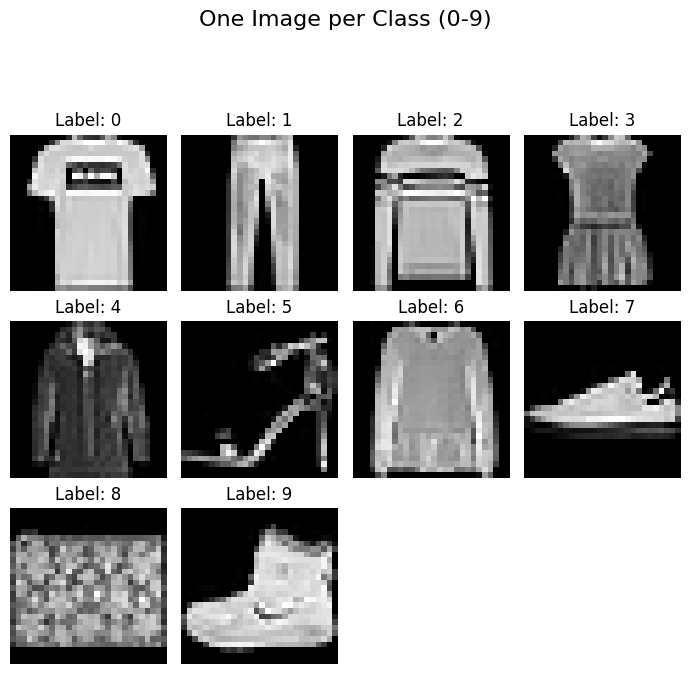

In [28]:
X_train, y_train, X_test, y_test, X_val, y_val = fashionMnist()

data = {
    "data_train": X_train,
    "labels_train": y_train,
    "data_val": X_test,
    "labels_val": y_test,
    "data_test": X_val,
    "labels_test": y_val,
}

print("Data shapes:")
for k, v in data.items():
    print("Name:  {} \t Shape: {}".format(k, v.shape))
print("\nClass labels:\n", np.unique(y_train))

# One image from each class
def show_one_image_per_class(X, y, num_classes=10):
    # Find one image for each class
    images = []
    labels = []

    for cls in range(num_classes):
        idx = np.where(y == cls)[0][0] # Get the first occurrence of each class
        images.append(X[idx])
        labels.append(y[idx])

    # Define row and column structure
    row_col_structure = [4, 4, 2]

    fig, axes = plt.subplots(3, max(row_col_structure), figsize=(7, 7))
    fig.suptitle("One Image per Class (0-9)", fontsize=16)

    img_idx = 0
    for row, cols in enumerate(row_col_structure):
        for col in range(cols):
            ax = axes[row, col]
            img = images[img_idx].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Label: {labels[img_idx]}")
            img_idx += 1

        # Hide unused subplots in each row
        for col in range(cols, max(row_col_structure)):
            axes[row, col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# Call the function
show_one_image_per_class(X_train, y_train)

In [29]:
def rel_error(x, y, eps=1e-8):
    """Returns the relative error between x and y."""
    return np.max(np.abs(x - y) / np.maximum(eps, np.abs(x) + np.abs(y)))


def eval_numerical_gradient_array(f, x, df, eps=1e-5):
    """
    Computes the numerical gradient of a function that returns a scalar.

    Arguments:
        f: function that accepts an array x and returns a scalar output.
        x: numpy array, the input.
        df: upstream gradient.
        eps: small step for finite differences.

    Returns:
        The numerical gradient (of f with respect to x) multiplied by df.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        old_val = x[idx]

        x[idx] = old_val + eps
        pos = f(x)
        x[idx] = old_val - eps
        neg = f(x)
        x[idx] = old_val
        grad[idx] = (np.sum(pos) - np.sum(neg)) / (2 * eps)

        it.iternext()
    return grad * df

## **Flatten Layer**   
The `flatten` class is a neural network layer that reshapes the input from a multi-dimensional tensor to a **2D matrix**, where the first dimension represents the **batch size**, and the second dimension flattens all other dimensions.

---

## **Implementation Details**  

### **`forward(x)`**   (2 points)
- Takes an input `x` of shape **(N, d1, d2, ..., dK)** and reshapes it into **(N, -1)**.  
- Stores the original shape (`x`) in `self.meta` to restore it during the backward pass.  
- Returns the reshaped output.  

---

### **`backward(dout)`**  (2 points)
- Restores the original shape of `dout` using `self.meta`, ensuring correct gradient flow.  
- Returns `dx`, which has the same shape as the original input.  

In [30]:
class flatten(object):
    """
    Reshapes the input from (N, d1, d2, ..., dK) to (N, -1).
    """
    def __init__(self, name="flatten"):
        self.name = name
        self.params = {}
        self.grads = {}
        self.meta = None

    def forward(self, x):
        # ====== TODO ======

        out = x.reshape(x.shape[0], -1)

        # ========================================
        self.meta = x
        return out

    def backward(self, dout):
        x = self.meta
        # ====== TODO ======

        dx = dout.reshape(x.shape)
        
        # ========================================
        self.meta = None
        return dx

In [31]:
print("========== Test flatten layer ==========")

input_bz = 2
input_dim = (3,4)
x = np.random.randn(input_bz, *input_dim)
flatten_test_layer = flatten(name="flatten_test")

out = flatten_test_layer.forward(x)
print("Flatten forward shape check:", out.shape, "should be (2, 12).")

dout = np.random.randn(*out.shape)
dx = flatten_test_layer.backward(dout)
print("Flatten backward shape check:", dx.shape, "should be (2, 3, 4).")

def forward_func(xx):
    out_ = flatten_test_layer.forward(xx)
    return np.sum(out_ * dout)

dx_num = eval_numerical_gradient_array(forward_func, x, 1.0)
print("Flatten dx error:", rel_error(dx, dx_num), "should be around 1e-10.")

========== Test flatten layer ==========
Flatten forward shape check: (2, 12) should be (2, 12).
Flatten backward shape check: (2, 3, 4) should be (2, 3, 4).
Flatten dx error: 7.269171776976849e-10 should be around 1e-10.


## **Fully-Connected Layer**
The `fc class` is a neural network layer that performs an affine transformation: y = xW + b, where W is the weight matrix and b is the bias vector.

---

## **Implementation Details**
### **`forward(x)`** (2 points)
- Takes an input x of shape (N, D) and computes y = xW + b.
- Stores the input (x) in self.meta for use during the backward pass.
Returns the computed output.

### **`backward(dout)`**  (2 points)

- Retrieves the cached input (x) from self.meta.
- Computes gradients with respect to the input (dx), weights (dw), and biases (db).
- Saves dw and db in self.grads.
- Returns dx, ensuring proper gradient flow.

In [32]:
class fc(object):
    """
    Fully-connected layer: y = xW + b.
    """
    def __init__(self, input_dim, output_dim, init_scale=1e-2, name="fc"):
        self.name = name
        # Name the weight and bias for easy lookup in dictionaries.
        self.w_name = name + "_w"
        self.b_name = name + "_b"

        # Initialize parameters
        self.params = {}
        self.grads = {}

        self.params[self.w_name] = init_scale * np.random.randn(input_dim, output_dim)
        self.params[self.b_name] = np.zeros(output_dim)

        self.grads[self.w_name] = None
        self.grads[self.b_name] = None

        self.meta = None

    def forward(self, x):
        # ====== TODO ======

        out = x @ self.params[self.w_name] + self.params[self.b_name]

        # ========================================
        self.meta = x
        return out


    def backward(self, dout):
        x = self.meta
        # ====== TODO ======
        dw = x.T @ dout
        db = np.sum(dout, axis=0)
        dx = dout @ self.params[self.w_name].T
        # ========================================
        self.grads[self.w_name] = dw
        self.grads[self.b_name] = db
        self.meta = None
        return dx

In [33]:
print("========== Test fc layer forward ==========")
fc_test_layer = fc(12, 5, init_scale=1e-2, name="fc_test")
fc_test_layer.params["fc_test_w"] = np.linspace(-0.2, 0.3, num=12*5).reshape(12,5)
fc_test_layer.params["fc_test_b"] = np.linspace(-0.1, 0.1, num=5)

test_out = fc_test_layer.forward(out)
print("FC forward output:", test_out)
print("Check shape:", test_out.shape, "should be (2,5).")

print("========== Test fc layer backward ==========")
dout2 = np.random.randn(*test_out.shape)
dx2 = fc_test_layer.backward(dout2)
print("dx2 shape:", dx2.shape, "should be (2,12) to match flatten out's shape.")

========== Test fc layer forward ==========
FC forward output: [[0.87792637 0.92417852 0.97043068 1.01668284 1.062935  ]
 [0.38390139 0.47547285 0.5670443  0.65861575 0.75018721]]
Check shape: (2, 5) should be (2,5).
========== Test fc layer backward ==========
dx2 shape: (2, 12) should be (2,12) to match flatten out's shape.


## **GELU Activation Function (`gelu`)**  
The **Gaussian Error Linear Unit (GELU)** is a smooth and differentiable activation function often used in transformer-based architectures like BERT. It is an alternative to ReLU and Swish.

## **Implementation Details**  

### **`forward(x)`**  (2 points)
- Computes the GELU activation using the **approximate formula**:
  \[
  y = 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715*x^3) ))
  \]
- Stores `x` in `self.meta` to use in the backward pass.
- Returns the activated output.

### **`backward(dout)`**  (2 points)
- Computes the
    \[
    y =0.5*(1 + tanh_) + 0.5*x*(1 - tanh_**2)*sqrt(2.0 / pi)*(1 + 3*0.044715*x**2)
    \]

- Returns the activated output.

---

## **Dropout Layer (`dropout`)**  
The **Dropout layer** is a regularization technique that randomly drops a fraction of neurons during training to prevent overfitting.

## **Implementation Details**  

### **`forward(x, is_training=True)`**  (2 points)
- If `is_training=True`:
  - Creates a **mask** with probability `keep_prob` to retain neurons.
  - Applies the mask to the input `x` by multiplying the retained neurons.
- If `is_training=False`, **dropout is disabled**, and the input is passed unchanged.
- Stores `x` in `self.meta` for backpropagation.

### **`backward(dout)`**  (2 points)
- If dropout was applied, **scales the gradient using the same mask**.
- Returns `dx`, the gradient with respect to the input.

---

## **Cross-Entropy Loss (`cross_entropy`)**  
The **Cross-Entropy Loss** is used for **multi-class classification**. It measures how well the predicted probability distribution matches the true labels.

## **Implementation Details**  

### **`forward(logits, labels)`**  (2 points)
- Applies **softmax** to transform logits into class probabilities.
- Computes the negative log-likelihood loss:
  \[
  L = - \sum \log P(\text{correct class})
  \]
- If `size_average=True`, **averages the loss over the batch**.
- Stores `logits` and `labels` for the backward pass.
- Returns the **scalar loss value**.

### **`backward()`**  (2 points)
- Computes the **gradient of the loss with respect to logits**:
  \[
  \frac{\partial L}{\partial x_i} = P(x_i) - 1 \text{ (for the correct class)}
  \]
- If `size_average=True`, the gradient is **normalized by batch size**.
- Returns `dx`, the gradient of the loss.

---

In [34]:
def softmax(x):
    """
    Computes the softmax function for the last dimension of x.

    Arguments:
        x: numpy array of shape (N, C)

    Returns:
        An array of the same shape as x with softmax applied.
    """
    s = np.sum(np.exp(x), axis=-1, keepdims=True)
    scores = np.exp(x) / s
    return scores

class gelu(object):
    """
    retrieved from https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
    GeLU activation function (approximate version):
    y = 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715*x^3) ))
    """
    def __init__(self, name="gelu"):
        self.name = name
        self.params = {}
        self.grads = {}
        self.meta = None

    def forward(self, x):
        # ====== TODO ======

         # GeLU activation function
        out = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

        # ========================================

        self.meta = x
        return out

    def backward(self, dout):
        x = self.meta
        # ====== TODO ======

        # Derivative of GeLU
        dx = dout * (0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3))) + 
                     0.5 * x * (1 - np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3))**2) *
                     np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * x**2))
        
        # ========================================
        self.meta = None
        return dx


class dropout(object):
    """
    Dropout layer.

    Arguments:
        keep_prob: probability of keeping a neuron.
        seed: random seed for reproducibility.
    """
    def __init__(self, keep_prob=1.0, seed=None, name="dropout"):
        self.name = name
        self.params = {}
        self.grads = {}
        self.keep_prob = keep_prob
        self.seed = seed
        self.meta = None
        self.mask = None
        self.is_training = False
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def forward(self, x, is_training=True):
        self.is_training = is_training
        if (self.keep_prob == 1.0) or (not is_training):
            out = x
            self.mask = np.ones_like(x)
        else:
            # ====== TODO ======

            # Perform dropout during training
            self.mask = (self.rng.rand(*x.shape) < self.keep_prob) / self.keep_prob
            out = x * self.mask

            # ========================================
        self.meta = x
        return out

    def backward(self, dout):
        if (self.keep_prob == 1.0) or (not self.is_training):
            dx = dout
        else:
            # ====== TODO ======

            dx = dout * self.mask

            # ========================================
        self.meta = None
        return dx


class cross_entropy(object):
    """
    Cross-entropy loss layer.
    The forward pass returns a scalar loss, and the backward pass returns the gradient with respect to logits.
    """
    def __init__(self, size_average=True):
        self.size_average = size_average
        self.logits = None
        self.labels = None

    def forward(self, logits, labels):
        """
        Arguments:
            logits: numpy array of shape (N, C).
            labels: numpy array of shape (N,) with integer labels in [0, C-1].

        Returns:
            Scalar loss value.
        """
        self.logits = logits
        self.labels = labels  # Store labels here
        probs = softmax(logits)
        # ====== TODO ======

        # Compute cross-entropy loss
        N = logits.shape[0]
        log_probs = np.log(probs[np.arange(N), labels])
        loss = -np.sum(log_probs) / N if self.size_average else -np.sum(log_probs)

        # ========================================

        return loss

    def backward(self):
        """
        Returns:
            Gradient with respect to logits, of shape (N, C).
        """
        probs = softmax(self.logits)
        labels = self.labels  # Use stored labels here
        N = labels.shape[0]
        # ====== TODO ======
        
        N = labels.shape[0]
        dx = probs
        dx[np.arange(N), labels] -= 1
        dx /= N
        
        # ========================================
        return dx

In [35]:
def forward_x(xx):
    old_x = out.copy()
    fc_test_layer.meta = xx
    ret = fc_test_layer.forward(xx)
    return ret

some_input_x = out

def forward_fc(xx):
    out_ = fc_test_layer.forward(xx)
    return np.sum(out_ * dout2)

dx_num2 = eval_numerical_gradient_array(forward_fc, some_input_x, 1.0)
print("fc backward dx error:", rel_error(dx2, dx_num2), 'should be around 1e-10.')

print("========== Test gelu forward/backward ==========")
gelu_layer = gelu(name="gelu_test")
x3 = np.random.randn(3,4)
out3 = gelu_layer.forward(x3)
dout3 = np.random.randn(*out3.shape)
dx3 = gelu_layer.backward(dout3)

def forward_gelu(xx):
    out_ = gelu_layer.forward(xx)
    return np.sum(out_ * dout3)

dx_num3 = eval_numerical_gradient_array(forward_gelu, x3, 1.0)
print("gelu backward dx error:", rel_error(dx3, dx_num3), 'should be around 1e-10.')

print("========== Test dropout forward/backward ==========")
drop_layer = dropout(keep_prob=0.5, seed=2023)
x4 = np.random.randn(4,4)
out4 = drop_layer.forward(x4, is_training=True)
print("Dropout out shape:", out4.shape)
dout4 = np.random.randn(*out4.shape)
dx4 = drop_layer.backward(dout4)

print("========== Test cross_entropy ==========")
ce_layer = cross_entropy()
test_logits = np.array([
    [1.0, 2.0, 3.0],
    [1.5, 0.9, -1.0]
])
test_labels = np.array([2, 0])

loss = ce_layer.forward(test_logits, test_labels)
dx_ = ce_layer.backward()
print("cross_entropy loss:", loss, 'should be around 0.448')

fc backward dx error: 5.944509618654704e-10 should be around 1e-10.
========== Test gelu forward/backward ==========
gelu backward dx error: 8.569014027918831e-10 should be around 1e-10.
========== Test dropout forward/backward ==========
Dropout out shape: (4, 4)
========== Test cross_entropy ==========
cross_entropy loss: 0.44836795533604257 should be around 0.448


In [36]:
class sequential(object):
    """
    A sequential container.
    Modules will be added to it in the order they are passed in the constructor.
    """
    def __init__(self, *layers):
        self.layers = []
        self.params = {}
        self.grads = {}
        for layer in layers:
            self.layers.append(layer)
            for pname, pval in layer.params.items():
                self.params[pname] = pval
            for gname, gval in layer.grads.items():
                self.grads[gname] = gval

    def forward(self, x, is_training=True):
        out = x
        for layer in self.layers:
            if layer.name.startswith("dropout"):
                out = layer.forward(out, is_training=is_training)
            else:
                out = layer.forward(out)
        return out

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            for gname, grad_val in layer.grads.items():
                self.grads[gname] = grad_val
        return dout

    def assign(self, name, value):
        self.params[name] = value
        for layer in self.layers:
            if name in layer.params:
                layer.params[name] = value

    def assign_grads(self, name, value):
        self.grads[name] = value
        for layer in self.layers:
            if name in layer.grads:
                layer.grads[name] = value


class FashionMnistNet(object):
    """
    test your implementation with this network
    """
    def __init__(self, hidden_dim=100, keep_prob=1.0, init_scale=1e-2):
        self.net = sequential(
            flatten(name="flat"),
            fc(28*28, hidden_dim, init_scale=init_scale, name="fc1"),
            gelu(name="gelu1"),
            dropout(keep_prob=keep_prob, name="dropout1"),
            fc(hidden_dim, 10, init_scale=init_scale, name="fc2"),
        )
        self.params = self.net.params
        self.grads  = self.net.grads

    def forward(self, x, is_training=True):
        return self.net.forward(x, is_training=is_training)

    def backward(self, dout):
        return self.net.backward(dout)

In [37]:
def accuracy(logits, labels):
    pred = np.argmax(logits, axis=-1)
    return np.mean(pred == labels)

def train_network(net,
                  X_tr, y_tr,
                  X_val, y_val,
                  lr=1e-2,
                  batch_size=128,
                  epochs=5):
    """
    Train the network.
    """
    loss_func = cross_entropy(size_average=True)

    N = X_tr.shape[0]
    train_acc_list = []
    val_acc_list = []
    loss_list = []
    for ep in range(epochs):
        # shuffle
        idx = np.random.permutation(N)
        X_tr_ = X_tr[idx]
        y_tr_ = y_tr[idx]

        num_batch = int(np.ceil(N / batch_size))
        for b in range(num_batch):
            start = b*batch_size
            end = min((b+1)*batch_size, N)
            xb = X_tr_[start:end]
            yb = y_tr_[start:end]

            # forward
            logits = net.forward(xb, is_training=True)
            if np.isnan(logits).any():
                print("Forward got NaN in logits")
            loss_val = loss_func.forward(logits, yb)

            # backward
            dLogits = loss_func.backward()
            net.backward(dLogits)
            for pname in net.params:
                if net.grads[pname] is None:
                    print("Gradient is None for param:", pname)
            for pname in net.params:
                net.params[pname] -= lr * net.grads[pname]

        # train/val acc
        loss_list.append(loss_val)
        train_preds = net.forward(X_tr, is_training=False)
        val_preds   = net.forward(X_val, is_training=False)
        train_acc = accuracy(train_preds, y_tr)
        val_acc = accuracy(val_preds, y_val)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch {ep+1}/{epochs}: loss={loss_val:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    return loss_list, train_acc_list, val_acc_list

In [38]:
# Training parameters
hidden_dim = 32
keep_prob=0.8
init_scale=1e-2
epochs = 20
lr = 1e-3
batch_size =32

# Training Loop
model = FashionMnistNet(hidden_dim=hidden_dim, keep_prob=keep_prob, init_scale=init_scale)
loss_list, train_acc_list, val_acc_list = train_network(
    model, X_train, y_train, X_val, y_val,
    lr=lr, batch_size=batch_size, epochs=epochs
)

Epoch 1/20: loss=2.2863, train_acc=0.3606, val_acc=0.3565
Epoch 2/20: loss=2.0734, train_acc=0.2461, val_acc=0.2390
Epoch 3/20: loss=1.6249, train_acc=0.4759, val_acc=0.4615
Epoch 4/20: loss=1.1727, train_acc=0.5592, val_acc=0.5405
Epoch 5/20: loss=1.1931, train_acc=0.6040, val_acc=0.5930
Epoch 6/20: loss=1.1282, train_acc=0.6386, val_acc=0.6190
Epoch 7/20: loss=0.8754, train_acc=0.6656, val_acc=0.6405
Epoch 8/20: loss=0.8921, train_acc=0.6783, val_acc=0.6585
Epoch 9/20: loss=0.8546, train_acc=0.6989, val_acc=0.6795
Epoch 10/20: loss=0.8086, train_acc=0.7088, val_acc=0.6895
Epoch 11/20: loss=0.6947, train_acc=0.7200, val_acc=0.6995
Epoch 12/20: loss=0.5403, train_acc=0.7308, val_acc=0.7100
Epoch 13/20: loss=0.8028, train_acc=0.7379, val_acc=0.7175
Epoch 14/20: loss=0.7529, train_acc=0.7471, val_acc=0.7285
Epoch 15/20: loss=0.5272, train_acc=0.7574, val_acc=0.7335
Epoch 16/20: loss=0.7339, train_acc=0.7614, val_acc=0.7400
Epoch 17/20: loss=0.8240, train_acc=0.7666, val_acc=0.7480
Epoch 

Final test accuracy: 0.774125


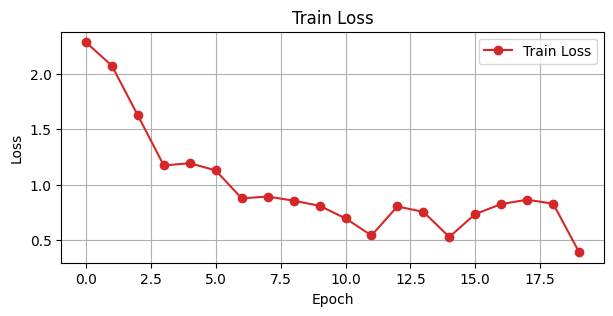

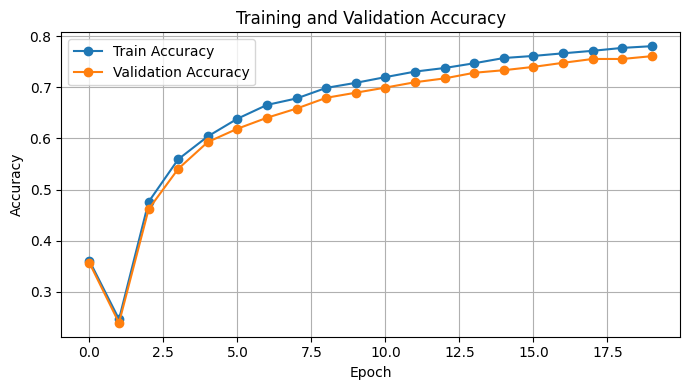

In [39]:
# Test
test_preds = model.forward(X_test, is_training=False)
test_acc = accuracy(test_preds, y_test)
print("Final test accuracy:", test_acc)

# Plot 1: Train Loss
plt.figure(figsize=(7, 3))
plt.title("Train Loss")
plt.plot(loss_list, '-o', color='tab:red', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot 2: Train and Validation Accuracy
plt.figure(figsize=(7, 4))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc_list, '-o', label="Train Accuracy")
plt.plot(val_acc_list, '-o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Implementing different optimizers (2 points per optimizazer, 10 points total)
In this part of the assignment, you will be asked to implement a few different commonly used optimizers inside of neural network. After the implementation, we will create a simple neural network to see how much of different in model convergence can be impacted by optimizer alone.


## SGD (Stochastic Gradient Descent):
SGD is a fundamental optimization algorithm that updates model parameters by computing the gradient of the loss with respect to a single example or a mini-batch. Its simplicity and computational efficiency make it a baseline method for training models, though it can be sensitive to noise and may converge slowly in certain scenarios.

In [40]:
import numpy as np

class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, params, grads):
        # params: list of numpy arrays (the current weights)
        # grads: list of numpy arrays (the corresponding gradients)
        updated_params = []
        for p, g in zip(params, grads):
            # ====== TODO ======
            
            updated_param = p - self.learning_rate * g  # Apply SGD update rule

            # ========================================
            updated_params.append(updated_param)
        return updated_params

N = 4
D = 5
p = np.linspace(-0.7, 0.4, num=N*D).reshape(N, D)
grad = 2 * p  # For each element, gradient = 2*x.
learning_rate = 0.1
epsilon = 1e-8

# ------------------------
# Test SGD:
expected_sgd = [[-0.56      , -0.51368421, -0.46736842, -0.42105263, -0.37473684],
 [-0.32842105, -0.28210526, -0.23578947, -0.18947368, -0.14315789],
 [-0.09684211, -0.05052632, -0.00421053,  0.04210526,  0.08842105],
 [ 0.13473684,  0.18105263,  0.22736842,  0.27368421,  0.32      ]]
sgd_optimizer = SGD(learning_rate=learning_rate)
updated_sgd = sgd_optimizer.update([p.copy()], [grad])[0]
if np.allclose(updated_sgd, expected_sgd, atol=1e-6):
    print("SGD test passed!")
else:
    print("SGD test failed: expected", expected_sgd, "got", updated_sgd)

SGD test passed!


## SGD with Momentum:
This variant of SGD introduces a momentum term that accumulates past gradients to smooth updates. By incorporating a velocity vector, the optimizer is better able to overcome small local minima and oscillations, often resulting in faster convergence. The momentum term helps the algorithm "remember" previous directions, thereby accelerating progress in relevant directions.

In [41]:
class SGDMomentum:
    def __init__(self, learning_rate, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = None  # This will be a list of velocities for each parameter

    def update(self, params, grads):
        if self.velocity is None:
            self.velocity = [np.zeros_like(p) for p in params]
        updated_params = []
        for i, (p, g) in enumerate(zip(params, grads)):
            # ====== TODO ======
            
            # Apply momentum update
            self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * g
            updated_param = p + self.velocity[i]  # Update parameters

            # ========================================
            updated_params.append(updated_param)
        return updated_params

momentum = 0.9
sgdm_optimizer = SGDMomentum(learning_rate=learning_rate, momentum=momentum)
updated_mom_first = sgdm_optimizer.update([p.copy()], [grad])[0]
if np.allclose(updated_mom_first, expected_sgd, atol=1e-6):
    print("SGDMomentum first update test passed!")
else:
    print("SGDMomentum first update test failed: expected", expected_sgd, "got", updated_mom_first)

expected_sgdm_second = [[-0.322     , -0.29536842, -0.26873684, -0.24210526, -0.21547368],
 [-0.18884211, -0.16221053, -0.13557895, -0.10894737, -0.08231579],
 [-0.05568421, -0.02905263, -0.00242105,  0.02421053,  0.05084211],
 [ 0.07747368,  0.10410526,  0.13073684,  0.15736842,  0.184     ],]

updated_mom_second = sgdm_optimizer.update([updated_mom_first.copy()], [2 * updated_mom_first])[0]
if np.allclose(updated_mom_second, expected_sgdm_second, atol=1e-6):
    print("SGDMomentum second update test passed!")
else:
    print("SGDMomentum second update test failed: expected", expected_sgdm_second, "got", updated_mom_second)

SGDMomentum first update test passed!
SGDMomentum second update test passed!


## RMSProp:
RMSProp (Root Mean Square Propagation) is an adaptive learning rate method that divides the learning rate for each parameter by a running average of the magnitudes of recent gradients. This normalization helps to balance the step sizes and stabilize the training process, particularly in non-stationary or noisy environments. RMSProp effectively addresses the diminishing learning rate issue seen in earlier methods like AdaGrad.

In [42]:
class RMSProp:
    def __init__(self, learning_rate, decay_rate=0.99, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.cache = None  # to store running average of squared gradients

    def update(self, params, grads):
        if self.cache is None:
            self.cache = [np.zeros_like(p) for p in params]
        updated_params = []
        for i, (p, g) in enumerate(zip(params, grads)):
            # ====== TODO ======
            
            # Update cache
            self.cache[i] = self.decay_rate * self.cache[i] + (1 - self.decay_rate) * (g ** 2)
            # Compute RMSProp parameter update
            updated_param = p - (self.learning_rate / (np.sqrt(self.cache[i]) + self.epsilon)) * g

            # ========================================
            updated_params.append(updated_param)
        return updated_params


expected_rmsprop = [[ 0.3        , 0.35789474,  0.41578947,  0.47368421,  0.53157895],
 [ 0.58947368,  0.64736842,  0.70526316,  0.76315789,  0.82105263],
 [ 0.87894737,  0.93684211,  0.99473684, -0.94736842, -0.88947368],
 [-0.83157895, -0.77368421, -0.71578947, -0.65789474, -0.6       ],]
rmsprop_optimizer = RMSProp(learning_rate=learning_rate, decay_rate=0.99, epsilon=epsilon)
updated_rmsprop = rmsprop_optimizer.update([p.copy()], [grad])[0]
if np.allclose(updated_rmsprop, expected_rmsprop, atol=1e-6):
    print("RMSProp test passed!")
else:
    print("RMSProp test failed: expected", expected_rmsprop, "got", updated_rmsprop)

RMSProp test passed!


## Adam (Adaptive Moment Estimation):
Adam combines the benefits of both momentum (by maintaining an exponentially decaying average of past gradients) and adaptive learning rates (by keeping a moving average of squared gradients). Additionally, it applies bias correction to these estimates, which improves convergence, especially in problems with large parameter spaces and noisy gradients. Adam is widely used because it typically requires little tuning and performs robustly across various tasks.

In [43]:
class Adam:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1  # decay rate for first moment
        self.beta2 = beta2  # decay rate for second moment
        self.epsilon = epsilon
        self.m = None  # first moment
        self.v = None  # second moment
        self.t = 0     # time step

    def update(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        self.t += 1
        updated_params = []
        for i, (p, g) in enumerate(zip(params, grads)):
            # ====== TODO ======
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            
            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            
            # Compute bias-corrected second moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Update parameter
            updated_param = p - (self.learning_rate / (np.sqrt(v_hat) + self.epsilon)) * m_hat
            
            # ========================================
            updated_params.append(updated_param)
        return updated_params

expected_adam = [[-0.6       , -0.54210526, -0.48421053, -0.42631579, -0.36842105],
 [-0.31052632, -0.25263158, -0.19473684, -0.13684211, -0.07894737],
 [-0.02105263,  0.03684211,  0.09473684, -0.04736842,  0.01052632],
 [ 0.06842105,  0.12631579,  0.18421053,  0.24210526,  0.3       ],]
adam_optimizer = Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=epsilon)
updated_adam = adam_optimizer.update([p.copy()], [grad])[0]
if np.allclose(updated_adam, expected_adam, atol=1e-6):
    print("Adam test passed!")
else:
    print("Adam test failed: expected", expected_adam, "got", updated_adam)

Adam test passed!


## AdamW (Adam with Decoupled Weight Decay):
AdamW is a modification of the Adam optimizer that decouples the weight decay (regularization) term from the gradient-based update. In standard Adam, weight decay is often implemented in a way that can interfere with the adaptive learning rate mechanism. By decoupling these two aspects, AdamW allows for more effective regularization, often leading to improved generalization in deep learning models.

Hint: AdamW optimizer is an extended version of Adam optimizer

In [44]:
class AdamW:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.m = None
        self.v = None
        self.t = 0

    def update(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        self.t += 1
        updated_params = []
        for i, (p, g) in enumerate(zip(params, grads)):
            # ====== TODO ======

            # Apply weight decay separately
            p = p * (1 - self.learning_rate * self.weight_decay)

            # Compute biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            
            # Compute biased second moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            
            # Compute bias-corrected second moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Apply AdamW update
            updated_param = p - (self.learning_rate / (np.sqrt(v_hat) + self.epsilon)) * m_hat

            # ========================================
            updated_params.append(updated_param)
        return updated_params

weight_decay = 0.01
expected_adamw = [[-0.5993    , -0.54146316, -0.48362632, -0.42578947, -0.36795263],
 [-0.31011579, -0.25227895, -0.19444211, -0.13660526, -0.07876842],
 [-0.02093158,  0.03690526,  0.09474211, -0.04742105,  0.01041579],
 [ 0.06825263,  0.12608947,  0.18392632,  0.24176316,  0.2996    ]]
adamw_optimizer = AdamW(learning_rate=learning_rate, beta1=0.9, beta2=0.999,
                        epsilon=epsilon, weight_decay=weight_decay)
updated_adamw = adamw_optimizer.update([p.copy()], [grad])[0]
if np.allclose(updated_adamw, expected_adamw, atol=1e-6):
    print("AdamW test passed!")
else:
    print("AdamW test failed: expected", expected_adamw, "got", updated_adamw)

AdamW test passed!


## Compare the performance of different optimizers with a simple neural network

In [45]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights and biases
        self.params = {
            'W1': np.random.randn(input_dim, hidden_dim) * 0.01,
            'b1': np.zeros((1, hidden_dim)),
            'W2': np.random.randn(hidden_dim, output_dim) * 0.01,
            'b2': np.zeros((1, output_dim))
        }

    def forward(self, X):
        # Hidden layer
        self.cache = {}
        self.cache['Z1'] = np.dot(X, self.params['W1']) + self.params['b1']
        self.cache['A1'] = np.tanh(self.cache['Z1'])
        # Output layer (sigmoid for binary classification)
        self.cache['Z2'] = np.dot(self.cache['A1'], self.params['W2']) + self.params['b2']
        self.cache['A2'] = 1 / (1 + np.exp(-self.cache['Z2']))
        return self.cache['A2']

    def compute_loss(self, A2, y):
        m = y.shape[0]
        # Binary cross-entropy loss
        loss = -1/m * np.sum(y * np.log(A2 + 1e-8) + (1 - y) * np.log(1 - A2 + 1e-8))
        return loss

    def backward(self, X, y):
        m = y.shape[0]
        grads = {}
        A2 = self.cache['A2']
        dZ2 = A2 - y.reshape(-1, 1)  # assuming y is a vector of 0s and 1s
        grads['W2'] = np.dot(self.cache['A1'].T, dZ2) / m
        grads['b2'] = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = np.dot(dZ2, self.params['W2'].T)
        dZ1 = dA1 * (1 - self.cache['A1'] ** 2)  # derivative of tanh
        grads['W1'] = np.dot(X.T, dZ1) / m
        grads['b1'] = np.sum(dZ1, axis=0, keepdims=True) / m
        return grads

In [46]:
def SimpleNN_train(network, optimizer, optimizer_label, X_train, y_train, X_val, y_val, epochs=1000, print_every=100):
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        # --- Forward pass on training data ---
        A2_train = network.forward(X_train)
        loss = network.compute_loss(A2_train, y_train)
        loss_history.append(loss)

        # Compute training accuracy (threshold at 0.5)
        train_preds = (A2_train > 0.5).astype(int)
        train_acc = np.mean(train_preds == y_train)
        train_acc_history.append(train_acc)

        # --- Backward pass and parameter update ---
        grads = network.backward(X_train, y_train)
        # Gather parameters and corresponding gradients as lists
        params = [network.params['W1'], network.params['b1'],
                  network.params['W2'], network.params['b2']]
        grads_list = [grads['W1'], grads['b1'], grads['W2'], grads['b2']]
        updated_params = optimizer.update(params, grads_list)
        network.params['W1'], network.params['b1'], network.params['W2'], network.params['b2'] = updated_params

        # --- Forward pass on validation data ---
        A2_val = network.forward(X_val)
        val_preds = (A2_val > 0.5).astype(int)
        val_acc = np.mean(val_preds == y_val)
        val_acc_history.append(val_acc)

        if epoch % print_every == 0:
            print(f"{optimizer_label} Epoch {epoch:04d}: Loss = {loss:.4f}, Train Acc = {train_acc*100:.2f}%, Val Acc = {val_acc*100:.2f}%")

    return loss_history, train_acc_history, val_acc_history

sgd Epoch 0000: Loss = 0.6931, Train Acc = 53.20%, Val Acc = 59.00%
sgd Epoch 0200: Loss = 0.6931, Train Acc = 51.60%, Val Acc = 57.00%
sgd Epoch 0400: Loss = 0.6930, Train Acc = 51.80%, Val Acc = 57.00%
sgd Epoch 0600: Loss = 0.6927, Train Acc = 52.20%, Val Acc = 57.00%
sgd Epoch 0800: Loss = 0.6921, Train Acc = 52.60%, Val Acc = 58.00%
sgdm Epoch 0000: Loss = 0.6932, Train Acc = 46.80%, Val Acc = 41.00%
sgdm Epoch 0200: Loss = 0.6910, Train Acc = 53.20%, Val Acc = 59.00%
sgdm Epoch 0400: Loss = 0.5233, Train Acc = 75.60%, Val Acc = 72.00%
sgdm Epoch 0600: Loss = 0.1831, Train Acc = 94.00%, Val Acc = 96.00%
sgdm Epoch 0800: Loss = 0.1389, Train Acc = 95.00%, Val Acc = 98.00%
rms Epoch 0000: Loss = 0.6932, Train Acc = 47.60%, Val Acc = 52.00%
rms Epoch 0200: Loss = 0.1096, Train Acc = 99.00%, Val Acc = 100.00%
rms Epoch 0400: Loss = 0.0625, Train Acc = 99.60%, Val Acc = 100.00%
rms Epoch 0600: Loss = 0.0463, Train Acc = 99.60%, Val Acc = 100.00%
rms Epoch 0800: Loss = 0.0359, Train Acc

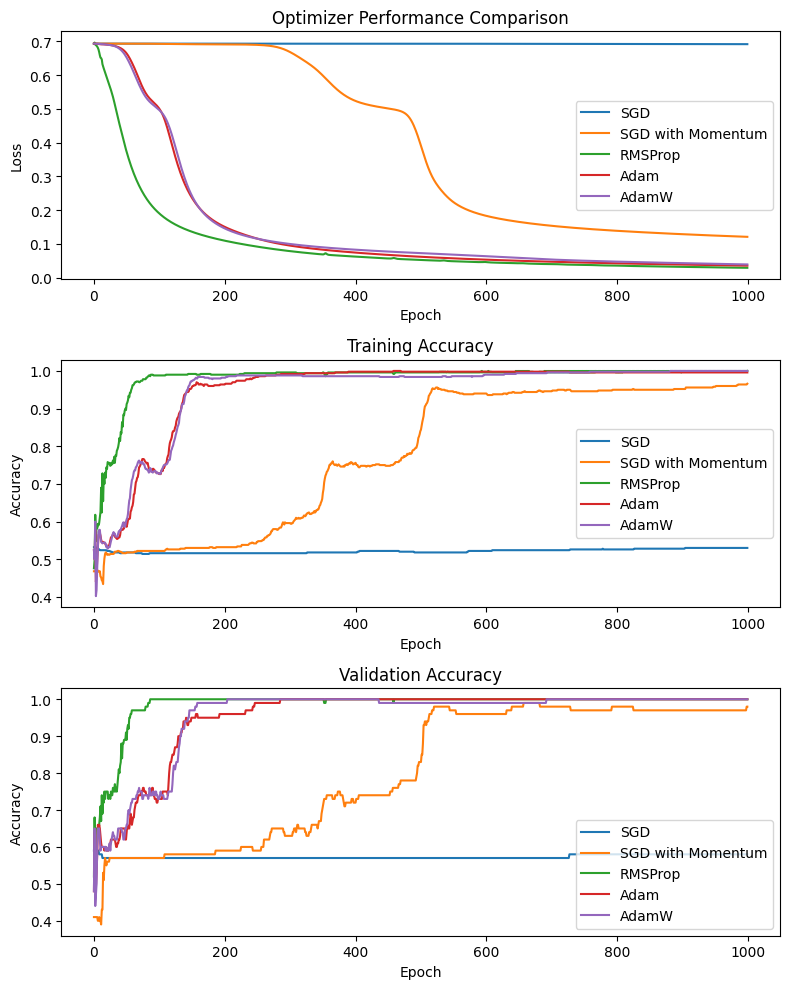

In [47]:
import matplotlib.pyplot as plt

# Generate a synthetic binary classification dataset
def generate_data(n_samples=500):
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)
    # Label is 1 if the sum of squares > median, else 0
    y = (np.sum(X**2, axis=1) > np.median(np.sum(X**2, axis=1))).astype(int)
    return X, y.reshape(-1,1)

X, y = generate_data(500)
split_idx = int(0.8 * X.shape[0])
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# Initialize networks (all networks share the same architecture)
net_sgd = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1)
net_mom = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1)
net_rms = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1)
net_adam = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1)
net_adamw = SimpleNN(input_dim=2, hidden_dim=10, output_dim=1)

# Create optimizer instances with chosen hyperparameters
optimizer_sgd = SGD(learning_rate=0.1)
optimizer_mom = SGDMomentum(learning_rate=0.1, momentum=0.9)
optimizer_rms = RMSProp(learning_rate=0.01, decay_rate=0.99, epsilon=1e-8)
optimizer_adam = Adam(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8)
optimizer_adamw = AdamW(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01)

# Train networks and record loss history
loss_sgd, train_acc_sgd, val_acc_sgd   = SimpleNN_train(net_sgd, optimizer_sgd, 'sgd', X, y, X_val, y_val, epochs=1000, print_every=200)
loss_mom, train_acc_mom, val_acc_mom   = SimpleNN_train(net_mom, optimizer_mom, 'sgdm', X, y, X_val, y_val, epochs=1000, print_every=200)
loss_rms, train_acc_rms, val_acc_rms   = SimpleNN_train(net_rms, optimizer_rms, 'rms', X, y, X_val, y_val, epochs=1000, print_every=200)
loss_adam, train_acc_adam, val_acc_adam  = SimpleNN_train(net_adam, optimizer_adam, 'adam', X, y, X_val, y_val, epochs=1000, print_every=200)
loss_adamw, train_acc_adamw, val_acc_adamw = SimpleNN_train(net_adamw, optimizer_adamw, 'adamW', X, y, X_val, y_val, epochs=1000, print_every=200)

# Plot training loss curves for each optimizer
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_mom, label='SGD with Momentum')
plt.plot(loss_rms, label='RMSProp')
plt.plot(loss_adam, label='Adam')
plt.plot(loss_adamw, label='AdamW')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Performance Comparison')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_acc_sgd, label='SGD')
plt.plot(train_acc_mom, label='SGD with Momentum')
plt.plot(train_acc_rms, label='RMSProp')
plt.plot(train_acc_adam, label='Adam')
plt.plot(train_acc_adamw, label='AdamW')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_acc_sgd, label='SGD')
plt.plot(val_acc_mom, label='SGD with Momentum')
plt.plot(val_acc_rms, label='RMSProp')
plt.plot(val_acc_adam, label='Adam')
plt.plot(val_acc_adamw, label='AdamW')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Using the plot above, answer the following questions:

## **1. What did you observe from the plot? (2 points)**

### **Observations from the Plot:**
- **SGD** performs poorly, with a nearly flat loss curve and low accuracy in both training and validation.
- **SGD with Momentum, RMSProp, Adam, and AdamW** all converge much faster and reach lower loss values compared to plain SGD.
- **Adam and AdamW** provide the **smoothest and fastest convergence**, maintaining high accuracy.
- **SGD with Momentum and RMSProp** also perform well, but **SGD with Momentum converges faster than RMSProp**.
- **RMSProp exhibits some instability**, as seen in the oscillations in training and validation accuracy.
- **AdamW performs similarly to Adam**, but it may generalize better due to decoupled weight decay.

---

## **2. Why does SGD give a nearly flat loss curve, and how to fix it? (2 points)**

### **Reason:**
Plain **SGD has slow convergence**, especially in complex loss landscapes, because it lacks **adaptive learning rates and momentum**. It struggles with **high-curvature regions and saddle points**, leading to minimal updates and stagnation.

### **Fix:**
- **Use a smaller batch size** to introduce noise, which can help escape local minima.  
- **Increase the learning rate** or use **learning rate decay** to allow better exploration.  
- **Use SGD with Momentum, RMSProp, or Adam**, which adaptively adjust updates for faster convergence.  

## Plot the Activation Functions (2 points per activation function, 16 points total)
In each of the activation function, use the given lambda function template to plot their corresponding curves. Do not use implemented library functions.
\begin{align*}
1.\ & \textbf{Sigmoid Function:} \quad \sigma(x) = \frac{1}{1 + e^{-x}} \\[10pt]
2.\ & \textbf{Tanh (Hyperbolic Tangent):} \quad f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} \\[10pt]
3.\ & \textbf{ReLU (Rectified Linear Unit):} \quad f(x) = \max(0, x) \\[10pt]
4.\ & \textbf{Leaky ReLU (Rectified Linear Unit):} \quad
   f(x) =
   \begin{cases}
      x, & \text{if } x > 0 \\
      \alpha x, & \text{if } x \leq 0
   \end{cases} \\[10pt]
5.\ & \textbf{ELU (Exponential Linear Unit):} \quad
   f(x) =
   \begin{cases}
      x, & \text{if } x > 0 \\
      \alpha (e^x - 1), & \text{if } x \leq 0
   \end{cases} \\[10pt]
6.\ & \textbf{Softplus Function:} \quad \text{Softplus}(x) = \ln(1 + e^x) \\[10pt]
7.\ & \textbf{GELU (Gaussian Error Linear Unit):} \quad
   \text{GELU}(x) = \frac{1}{2}x \left(1 + \tanh \left[\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right]\right) \\[10pt]
8.\ & \textbf{Softmax Function:} \quad
   \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
\end{align*}


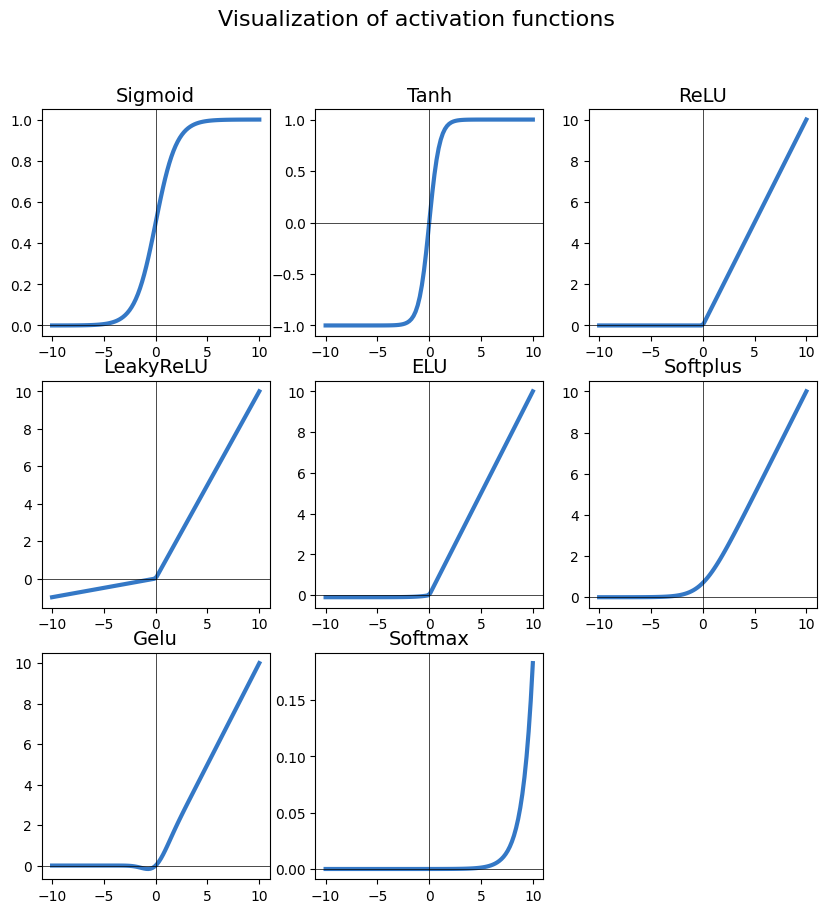

In [48]:
left, right = -10, 10
X  = np.linspace(left, right, 100)
XS = np.linspace(-5, 5, 10)
lw = 3
alpha = 0.1 # alpha for leaky_relu and elu

# ====== TODO ======

sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
relu = lambda x: np.maximum(0, x)
leaky_relu = lambda x: np.where(x > 0, x, alpha * x)
elu = lambda x: np.where(x > 0, x, alpha * (np.exp(x) - 1))
softplus = lambda x: np.log(1 + np.exp(x))
gelu = lambda x: 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

# ========================================

activations = {
    "Sigmoid": sigmoid,
    "Tanh": tanh,
    "ReLU": relu,
    "LeakyReLU": leaky_relu,
    "ELU": elu,
    "Softplus": softplus,
    "Gelu": gelu,
    "Softmax": softmax,
}


# Ground Truth activations
GT_Act = {
    "Sigmoid": [0.00669285, 0.02005754, 0.0585369,  0.1588691,  0.36457644,
                0.63542356, 0.8411309,  0.9414631,  0.97994246, 0.99330715],

    "Tanh": [-0.9999092,  -0.99916247, -0.99229794, -0.93110961, -0.5046724,
             0.5046724, 0.93110961,  0.99229794,  0.99916247,  0.9999092],

    "ReLU": [0., 0., 0., 0., 0., 0.55555556, 1.66666667, 2.77777778, 3.88888889, 5.],

    "LeakyReLU": [-0.5 , -0.38888889, -0.27777778, -0.16666667, -0.05555556, 
                0.55555556, 1.66666667, 2.77777778, 3.88888889, 5. ],

    "ELU": [-0.09932621, -0.09795319, -0.09378235, -0.08111244, -0.04262466, 
            0.55555556, 1.66666667, 2.77777778, 3.88888889, 5. ],

    "Softplus": [0.00671535, 0.02026142, 0.06032013, 0.17300799, 0.45346348,
                 1.00901904, 1.83967466, 2.83809791, 3.90915031, 5.00671535],

    "Gelu": [-2.29179620e-07, -1.18062300e-04, -7.13321406e-03, -7.98024027e-02,
             -1.60723677e-01,  3.94831879e-01,  1.58686426e+00, 2.77064456e+00,
             3.88877083e+00, 4.99999977e+00],

    "Softmax": [3.04550464e-05, 9.25142622e-05, 2.81033514e-04, 8.53704437e-04,
                2.59332510e-03, 7.87782605e-03, 2.39307225e-02, 7.26951163e-02,
                2.20828265e-01, 6.70817038e-01]
}

fig = plt.figure(figsize=(10,10))
for i, label in enumerate(activations):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(X, activations[label](X), color=(52/255,120/255,198/255), lw=lw, label=label)
    # print(activations[label](XS))
    assert rel_error(activations[label](XS), GT_Act[label]) < 1e-6, \
           "Your implementation of {} might be wrong".format(label)
    ax.axhline(0, color='black', lw = 0.5)
    ax.axvline(0, color='black', lw = 0.5)
    ax.set_title('{}'.format(label), fontsize=14)
    fig.suptitle("Visualization of activation functions", fontsize=16)

plt.show()